In [ ]:
#####recibe la data de sentencias extorsivas y lo aplana y convierte en una lista de palabras

In [11]:
import pandas as pd
import re
import unicodedata

def normalizar(texto):
    """Normaliza el texto a minúsculas, elimina acentos y caracteres especiales, excepto guiones."""
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    return texto

def construir_diccionario(df):
    """
    Construye un diccionario de palabras únicas y normalizadas a partir de la columna 'sentences' de un DataFrame.
    """
    diccionario = set()
    for sentencia in df['sentences'].dropna():
        # Encuentra palabras que contienen letras, números y guiones.
        palabras = re.findall(r'\b[\w-]+\b', normalizar(sentencia))
        diccionario.update(palabras)
    return diccionario

if __name__ == "__main__":
    file_path = "datav2.xlsx"
    
    try:
        # Lee el archivo de Excel
        df = pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo en la ruta: {file_path}")
        exit()

    # Construye el diccionario a partir de la data
    diccionario_sentencias = construir_diccionario(df)
    
    # Crea un DataFrame a partir del diccionario y lo guarda en un archivo de Excel
    df_diccionario = pd.DataFrame(sorted(list(diccionario_sentencias)), columns=['Palabras en el Diccionario'])
    output_path_diccionario = "lista_palabras.xlsx"
    df_diccionario.to_excel(output_path_diccionario, index=False)
    
    print(f'El diccionario ha sido generado y guardado en: {output_path_diccionario}')

El diccionario ha sido generado y guardado en: lista_palabras.xlsx


In [ ]:
###Genera un diccionario con plabras relacionadas a la demanda y palabras relacionadas a la amenaza por similitud

In [15]:
import spacy
import pandas as pd
import os

# --- Cargar el modelo de spaCy con vectores de palabras ---
# Los vectores de palabras son necesarios para calcular la similitud.
# Si usas el modelo 'es_core_news_sm' y te da un error,
# necesitas el modelo grande 'es_core_news_lg'
try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    print("El modelo 'es_core_news_sm' no se encontró. Descargando el modelo 'lg'...")
    os.system("python -m spacy download es_core_news_lg")
    nlp = spacy.load("es_core_news_lg")

# --- Palabras de anclaje para la clasificación ---
# Estas palabras definen los conceptos de "demanda" y "amenaza".
demanda_anchors = nlp("pagar depositar dinero billete cuota")
threat_anchors = nlp("matar golpear sufrir daño sangre")

def classify_word(word):
    """
    Clasifica una palabra como 'demanda' o 'amenaza' usando similitud semántica.
    """
    if not isinstance(word, str):
        return None
    
    token = nlp(word.lower())
    
    # Excluye palabras que no son verbos o sustantivos, y palabras de una sola letra
    if len(token) == 1 and token[0].pos_ not in ['VERB', 'NOUN'] and len(word) > 2:
        return None

    # Calcula la similitud promedio con las palabras de anclaje
    try:
        demanda_score = token.similarity(demanda_anchors)
        threat_score = token.similarity(threat_anchors)
    except ValueError:
        # Esto ocurre si el token no tiene vector (ej. números, signos)
        return None
        
    # Asigna la palabra a la categoría con mayor puntuación
    if demanda_score > threat_score:
        return 'Demanda'
    elif threat_score > demanda_score:
        return 'Amenaza'
    else:
        return 'No definido'

# --- Procesar el diccionario de palabras ---
diccionario_file = "lista_palabras.xlsx"

try:
    # Lee el archivo de Excel con la única columna
    df_diccionario = pd.read_excel(diccionario_file, sheet_name='Sheet1')
    df_diccionario.columns = ['Palabra']
    
except FileNotFoundError:
    print(f"Error: El archivo '{diccionario_file}' no se encontró.")
    exit()
except KeyError:
    print("Error: Asegúrate de que tu hoja de cálculo tenga una columna llamada 'Palabras en el Diccionario'.")
    exit()

# Crea las columnas de demanda y amenaza
df_clasificado = pd.DataFrame(columns=['Palabras de Demanda', 'Palabras de Amenaza'])
demanda_list = []
amenaza_list = []

# Clasifica cada palabra del diccionario
for word in df_diccionario['Palabra'].dropna().unique():
    category = classify_word(word)
    if category == 'Demanda':
        demanda_list.append(word)
    elif category == 'Amenaza':
        amenaza_list.append(word)

# Rellena el nuevo DataFrame con las listas clasificadas
max_len = max(len(demanda_list), len(amenaza_list))
df_clasificado['Palabras de Demanda'] = pd.Series(demanda_list, dtype='object').reindex(range(max_len))
df_clasificado['Palabras de Amenaza'] = pd.Series(amenaza_list, dtype='object').reindex(range(max_len))

# Guarda el nuevo diccionario clasificado en un archivo de Excel
output_file = "diccionario_clasificado.xlsx"
df_clasificado.to_excel(output_file, index=False)

print("\nClasificación del diccionario completada.")
print(f"El nuevo diccionario se ha guardado en '{output_file}'.")

C:\Users\Jorge1612\AppData\Local\Temp\ipykernel_16316\719422077.py:36: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  demanda_score = token.similarity(demanda_anchors)
C:\Users\Jorge1612\AppData\Local\Temp\ipykernel_16316\719422077.py:37: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sen


Clasificación del diccionario completada.
El nuevo diccionario se ha guardado en 'diccionario_clasificado.xlsx'.


In [ ]:
#Este algoritmo clasifica las sentencias en sus cuatro categorias 
#Tipo 01: demanda en voz activa + amenaza en voz pasiva

#Tipo 02: demanda con verbo imperativo + amenaza en voz activa

#Tipo 03: amenaza en voz activa + demanda en voz activa (o ambas activas)

#TIPO 04 NO EXTORSIVO

In [16]:
import spacy
import pandas as pd
import os

# --- Cargar el modelo de spaCy y el diccionario de verbos clasificado ---

try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    print("El modelo 'es_core_news_sm' no está descargado. Por favor, ejecuta: python -m spacy download es_core_news_sm")
    exit()

demand_verbs = set()
threat_verbs = set()
diccionario_file = "diccionario_clasificado.xlsx"

try:
    # Cargar el nuevo diccionario clasificado
    df_diccionario = pd.read_excel(diccionario_file)
    
    demand_verbs = set(df_diccionario['Palabras de Demanda'].dropna().str.lower().tolist())
    threat_verbs = set(df_diccionario['Palabras de Amenaza'].dropna().str.lower().tolist())
    
    print("Diccionario de verbos clasificado cargado exitosamente.")
    print(f"Verbos de Demanda: {len(demand_verbs)} encontrados.")
    print(f"Verbos de Amenaza: {len(threat_verbs)} encontrados.")

except FileNotFoundError:
    print(f"Error: El archivo '{diccionario_file}' no se encontró. Asegúrate de haber ejecutado el script de clasificación del diccionario.")
    exit()
except KeyError:
    print("Error: Las columnas 'Palabras de Demanda' o 'Palabras de Amenaza' no se encontraron en el diccionario clasificado.")
    exit()

# --- Funciones de Clasificación ---

def classify_sentence(sentence):
    """
    Clasifica una oración de extorsión en uno de los tres tipos definidos.
    """
    if not isinstance(sentence, str):
        return "No Extorsión"
    
    doc = nlp(sentence.lower())
    
    has_demand = False
    is_demand_imperative = False
    has_threat = False
    is_threat_passive = False
    
    # Detección de la Demanda
    for token in doc:
        if token.lemma_ in demand_verbs or token.text in demand_verbs:
            has_demand = True
            if token.pos_ == "VERB" and "VerbForm=Fin" in token.morph and "Mood=Imp" in token.morph:
                is_demand_imperative = True
                
    # Detección de la Amenaza
    for token in doc:
        if token.lemma_ in threat_verbs:
            has_threat = True
            if any(child.dep_ == "nsubjpass" for child in token.children):
                is_threat_passive = True
                break
    
    # Lógica de Clasificación
    if not has_demand or not has_threat:
        return "No Extorsión"
    
    if not is_demand_imperative and is_threat_passive:
        return "Tipo 01: demanda en voz activa + amenaza en voz pasiva"
    
    if is_demand_imperative and not is_threat_passive:
        return "Tipo 02: demanda con verbo imperativo + amenaza en voz activa"
    
    if not is_threat_passive and not is_demand_imperative:
        return "Tipo 03: amenaza en voz activa + demanda en voz activa"
    
    return "Tipo Desconocido/Mixto"

# --- Procesar el archivo principal de oraciones ---

sentences_file = "datav2.xlsx"

try:
    df = pd.read_excel(sentences_file, sheet_name='sentences')
    df['sentences'] = df['sentences'].astype(str)
    
except FileNotFoundError:
    print(f"Error: El archivo de oraciones '{sentences_file}' no se encontró. Asegúrate de que esté en la misma carpeta que el script.")
    exit()
except KeyError:
    print("Error: La hoja de cálculo 'e' o la columna 'sentences' no se encontraron en 'datav2.xlsx'.")
    exit()

# Crear una nueva columna para la clasificación
df['categoria_extorsion'] = df['sentences'].apply(classify_sentence)

# Guardar los resultados en un nuevo archivo XLSX
output_file = "sentences_clasificadas.xlsx"
df.to_excel(output_file, index=False)

print("\nAnálisis completado.")
print(f"Los resultados se han guardado en '{output_file}' en formato Excel.")

Diccionario de verbos clasificado cargado exitosamente.
Verbos de Demanda: 356 encontrados.
Verbos de Amenaza: 171 encontrados.

Análisis completado.
Los resultados se han guardado en 'sentences_clasificadas.xlsx' en formato Excel.


In [ ]:
###esta parte repite el codigo de arriba para probarlo con una data que tiene sentencias extorsivas y no extorsivs y ver la matriz de confusion

In [1]:
import spacy
import pandas as pd
import os

# --- Cargar el modelo de spaCy y el diccionario de verbos clasificado ---

try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    print("El modelo 'es_core_news_sm' no está descargado. Por favor, ejecuta: python -m spacy download es_core_news_sm")
    exit()

demand_verbs = set()
threat_verbs = set()
diccionario_file = "diccionario_clasificado.xlsx"

try:
    # Cargar el nuevo diccionario clasificado
    df_diccionario = pd.read_excel(diccionario_file)
    
    demand_verbs = set(df_diccionario['Palabras de Demanda'].dropna().str.lower().tolist())
    threat_verbs = set(df_diccionario['Palabras de Amenaza'].dropna().str.lower().tolist())
    
    print("Diccionario de verbos clasificado cargado exitosamente.")
    print(f"Verbos de Demanda: {len(demand_verbs)} encontrados.")
    print(f"Verbos de Amenaza: {len(threat_verbs)} encontrados.")

except FileNotFoundError:
    print(f"Error: El archivo '{diccionario_file}' no se encontró. Asegúrate de haber ejecutado el script de clasificación del diccionario.")
    exit()
except KeyError:
    print("Error: Las columnas 'Palabras de Demanda' o 'Palabras de Amenaza' no se encontraron en el diccionario clasificado.")
    exit()

# --- Funciones de Clasificación ---

def classify_sentence(sentence):
    """
    Clasifica una oración de extorsión en uno de los tres tipos definidos.
    """
    if not isinstance(sentence, str):
        return "No Extorsión"
    
    doc = nlp(sentence.lower())
    
    has_demand = False
    is_demand_imperative = False
    has_threat = False
    is_threat_passive = False
    
    # Detección de la Demanda
    for token in doc:
        if token.lemma_ in demand_verbs or token.text in demand_verbs:
            has_demand = True
            if token.pos_ == "VERB" and "VerbForm=Fin" in token.morph and "Mood=Imp" in token.morph:
                is_demand_imperative = True
                
    # Detección de la Amenaza
    for token in doc:
        if token.lemma_ in threat_verbs:
            has_threat = True
            if any(child.dep_ == "nsubjpass" for child in token.children):
                is_threat_passive = True
                break
    
    # Lógica de Clasificación
    if not has_demand or not has_threat:
        return "No Extorsión"
    
    if not is_demand_imperative and is_threat_passive:
        return "Tipo 01: demanda en voz activa + amenaza en voz pasiva"
    
    if is_demand_imperative and not is_threat_passive:
        return "Tipo 02: demanda con verbo imperativo + amenaza en voz activa"
    
    if not is_threat_passive and not is_demand_imperative:
        return "Tipo 03: amenaza en voz activa + demanda en voz activa"
    
    return "Tipo Desconocido/Mixto"

# --- Procesar el archivo principal de oraciones ---

sentences_file = "matriz_confusion.xlsx"

try:
    df = pd.read_excel(sentences_file, sheet_name='sentences')
    df['SENTENCES'] = df['SENTENCES'].astype(str)
    
except FileNotFoundError:
    print(f"Error: El archivo de oraciones '{sentences_file}' no se encontró. Asegúrate de que esté en la misma carpeta que el script.")
    exit()
except KeyError:
    print("Error: La hoja de cálculo 'e' o la columna 'sentences' no se encontraron en 'datav2.xlsx'.")
    exit()

# Crear una nueva columna para la clasificación
df['categoria_extorsion'] = df['SENTENCES'].apply(classify_sentence)

# Guardar los resultados en un nuevo archivo XLSX
output_file = "sentences_clasificadas1.xlsx"
df.to_excel(output_file, index=False)

print("\nAnálisis completado.")
print(f"Los resultados se han guardado en '{output_file}' en formato Excel.")

Diccionario de verbos clasificado cargado exitosamente.
Verbos de Demanda: 356 encontrados.
Verbos de Amenaza: 171 encontrados.

Análisis completado.
Los resultados se han guardado en 'sentences_clasificadas1.xlsx' en formato Excel.


In [ ]:
###Matriz de confusion

[[944  26]
 [  0  16]]
Accuracy: 0.973630831643002
F1 score: 0.9864158829676071
Recall: 1.0
Precision: 0.9731958762886598

Classification report:
               precision    recall  f1-score   support

   EXTORSION       0.97      1.00      0.99       944
NO EXTORSION       1.00      0.38      0.55        42

    accuracy                           0.97       986
   macro avg       0.99      0.69      0.77       986
weighted avg       0.97      0.97      0.97       986



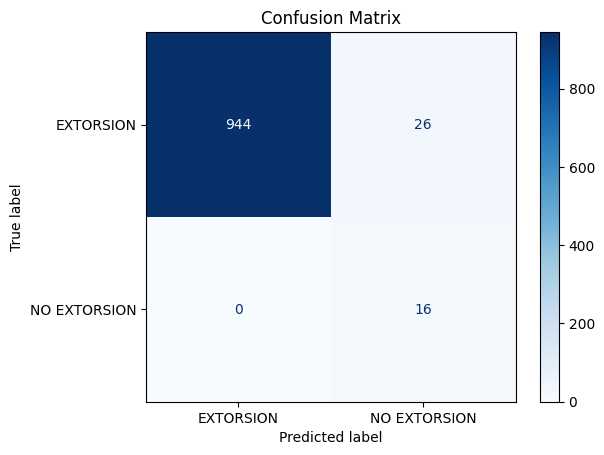

In [8]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,  accuracy_score, f1_score
data = pd.read_excel("matriz_confusion.xlsx", sheet_name="MATRIZ")
cm=confusion_matrix(data['PREDICTED'], data['REAL'])
print(cm)
###Indicar la clase positiva es decir 1 es EXTORSION y 0 NO EXTORSION
print ('Accuracy:', accuracy_score(data['REAL'], data['PREDICTED']))
print ('F1 score:', f1_score(data['REAL'], data['PREDICTED'], pos_label="EXTORSION"))
print ('Recall:', recall_score(data['REAL'], data['PREDICTED'], pos_label="EXTORSION"))
print ('Precision:', precision_score(data['REAL'], data['PREDICTED'], pos_label="EXTORSION"))
print ('\nClassification report:\n', classification_report(data['REAL'], data['PREDICTED']))
# Plot the confusion matrix
#https://medium.com/@eceisikpolat/plot-and-customize-multiple-confusion-matrices-with-matplotlib-a19ed00ca16c
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
display_labels = ["EXTORSION","NO EXTORSION"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig("confusion.png", dpi=300, bbox_inches="tight")
plt.show()